# Figure 8.

Latitudinal cross-section of the zonal transport of sensible ($c_p T$, black contours, solid - positive, dotted - negative) and latent ($Lq$, color shading) heat ($10^6~W~m^{-2}$) through the eastern terminator ($90^\circ E$) in (left column) the Trappist-1e case and (right column) the Proxima b case in (a, b) *MassFlux*, (c, d) *Adjust*, and (e, f) *NoCnvPm* simulations.

[Skip code and jump to the figure](#Show-the-figure)

----------------------------------

Import the necessary libraries.

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import iris

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

import numpy as np

In [3]:
from aeolus.calc import last_year_mean, spatial
from aeolus.coord_utils import UM_HGT, UM_LATLON, nearest_coord_value
from aeolus.core import Run
from aeolus.region import Region
from aeolus.subset import l_range_constr
from aeolus.util import fmt_lonlat, subplot_label_generator

In [4]:
from commons import (
    GLM_MODEL_TIMESTEP,
    PLANET_ALIASES,
    RUN_ALIASES,
    OUTPUT_NAME_PREFIX,
)
from gl_diag import calc_derived_cubes
import mypaths
from plot_func import MARKER_KW, add_aux_yticks, add_custom_legend, use_style
from utils import tex2cf_units

Global stylesheet for figures.

In [5]:
use_style()

## Load data

Create a dictionary of `Run` objects with preprocessed data.

In [6]:
runs = {}
for planet in PLANET_ALIASES.keys():
    for run_key in RUN_ALIASES.keys():
        label = f"{planet}_{run_key}"

        fname = mypaths.sadir / label / "_processed" / f"{label}.nc"

        runs[label] = Run(
            files=fname,
            name=label,
            planet=planet,
            timestep=GLM_MODEL_TIMESTEP,
            processed=True,
        )

        # Calculate additional diagnostics
        runs[label].add_data(calc_derived_cubes)

## Additional function

Calculate zonal heat flux of a scalar variable.

In [7]:
def calc_zonal_heat_flux(choice, cubelist, hgt_cnstr, longitude, tex_units):
    cube_units = tex2cf_units(tex_units)
    spatial_cnstr = hgt_cnstr & iris.Constraint(
        longitude=nearest_coord_value(cubelist[0], UM_LATLON[1], longitude)
    )
    const = cubelist[0].attributes["planet_conf"]

    if choice == "dry":
        scalar = cubelist.extract_strict("air_temperature").extract(spatial_cnstr)
        scalar *= const.dry_air_spec_heat_press.asc
    elif choice == "moist":
        scalar = cubelist.extract_strict("specific_humidity").extract(spatial_cnstr)
        scalar *= const.water_heat_vaporization.asc
    rho = cubelist.extract_strict("air_density").extract(spatial_cnstr)
    u = cubelist.extract_strict("x_wind").extract(spatial_cnstr)

    #     vcross_area = vertical_cross_section_area(
    #         u[0, ...], r_planet=init_const(planet).radius.data
    #     )
    #     _guess_bounds_lonlat(vcross_area)
    cube = last_year_mean(rho * u * scalar)  # * vcross_area
    cube.convert_units(cube_units)
    return cube

## Plot the results

Define the altitude extent, from 0 to 15 km.

In [8]:
HGT_0 = 0
HGT_1 = 16
hgt_cnstr = l_range_constr(HGT_0, HGT_1)

Define tick locations and contour levels

In [9]:
lat_ticks = np.arange(-90, 91, 30)

In [10]:
m_levels = list(np.round(np.arange(-36.0, 36.01, 4), 2))
m_levels.remove(0)
m_levels = np.array(m_levels) / 1000
print(m_levels)

d_levels = list(np.round(np.arange(-20, 20, 1), 2))
d_levels.remove(0)
d_levels = np.array(d_levels)
print(d_levels)

[-0.036 -0.032 -0.028 -0.024 -0.02  -0.016 -0.012 -0.008 -0.004  0.004
  0.008  0.012  0.016  0.02   0.024  0.028  0.032  0.036]
[-20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3
  -2  -1   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19]


Plotting style for the dry and moist components of the heat flux.

In [11]:
dry_flux_kw = dict(levels=d_levels, colors="#222222", linewidths=0.5,)  # cmap="RdBu_r",
moist_flux_kw = dict(cmap="BrBG", levels=m_levels, extend="both")

Title style

In [12]:
ttl_kw = dict(fontsize="small", pad=5, loc="left")

Units

In [13]:
tex_units = "$10^6$ $W$ $m^{-2}$"

Location of the cross-section

In [14]:
THE_LON = 90

Define region boundaries

In [15]:
ncol = 2
nrow = 3

fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(8 * ncol, 4 * nrow))

iletters = subplot_label_generator()
for ax in axs.flat:
    if ax.is_first_row() and ax.is_first_col():
        ax.add_artist(AnchoredText(fmt_lonlat(THE_LON, "lon", True), loc=2))
    ax.set_title(f"({next(iletters)})", **ttl_kw)
    ax.set_ylim([HGT_0, HGT_1 - 1]) # show only up to 15 km
    ax.set_xticks(lat_ticks)
    ax.set_xticklabels([fmt_lonlat(i, "lat", True) for i in lat_ticks])

    if ax.is_first_col():
        ax.set_ylabel("Height [km]")
    if ax.is_last_row():
        ax.set_xlabel("Latitude [$\degree$]")

    ax.vlines(0, *ax.get_ylim(), color="#999999")


for planet, ax_col in zip(PLANET_ALIASES, axs.T):
    for run_key, ax in zip(RUN_ALIASES.keys(), ax_col):
        label = f"{planet}_{run_key}"
        ax.set_title(RUN_ALIASES[run_key], fontsize="medium", pad=5, loc="right")
        if run_key == "grcs":
            ax.set_title(PLANET_ALIASES[planet], fontsize="large", pad=5, loc="center")

        moist_flux = calc_zonal_heat_flux(
            "moist", runs[label].proc, hgt_cnstr, THE_LON, tex_units=tex_units
        )
        dry_flux = calc_zonal_heat_flux(
            "dry", runs[label].proc, hgt_cnstr, THE_LON, tex_units=tex_units
        )

        lats, heights = (
            moist_flux.coord(UM_LATLON[0]).points,
            moist_flux.coord(UM_HGT).points / 1e3,
        )

        h = ax.contourf(lats, heights, moist_flux.data, **moist_flux_kw)
        hh = ax.contour(lats, heights, dry_flux.data, **dry_flux_kw)
        clbls = ax.clabel(hh, fmt=r"%.0f")  # $\times 10^{3}$

plt.subplots_adjust(wspace=0.15, hspace=0.3)

cb = fig.colorbar(h, ax=axs, pad=0.025, fraction=0.1, aspect=40, orientation="vertical")
cb.set_ticks(moist_flux_kw["levels"])
cb.set_label(f"Horizontal latent heat flux [{tex_units}]")
plt.close()  # Show the figure in a separate cell

## Show the figure

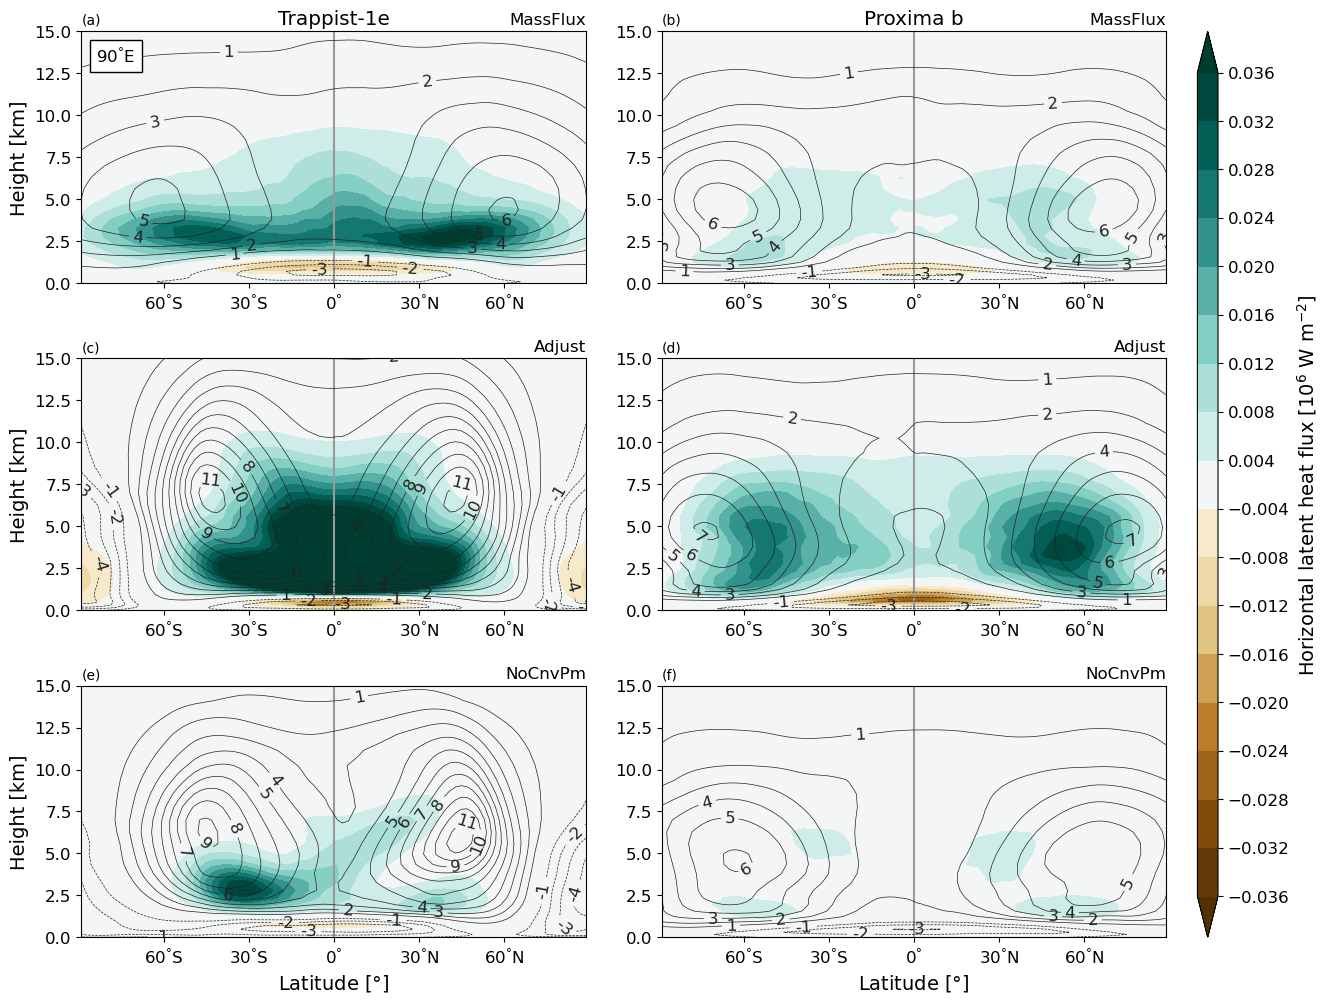

In [16]:
fig

And save it.

In [17]:
imgname = (
    mypaths.plotdir
    / f"{OUTPUT_NAME_PREFIX}__vcross_lon{fmt_lonlat(THE_LON, 'lon')}__hgt{HGT_0}-{HGT_1}__zonal_fluxes"
)

In [18]:
fig.savefig(imgname, dpi=200)
print(f"Saved to ../{imgname.relative_to(mypaths.topdir)}")

Saved to ../plots/trap1e_proxb__grcs_llcs_all_rain_acoff__vcross_lon90E__hgt0-16__zonal_fluxes
